Скачиваю dataset
Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

--2023-03-21 10:27:32--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-03-21 10:27:33--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7f0e3044774c5a7698b5c249e6.dl.dropboxusercontent.com/cd/0/inline/B4prUGpb6pWvjZqKwxJKvSlAMrgYYogkkJKv-Cki_fXfpXEaUYmKXgGjxzr3eIXNzcm4M90jyGCGTX0M_51FSVU0sEJ0YHRiwtkExaXZ4l5wqOkIvcJ__dMUZTvSiRet4BJ9gJmGhASPZAPv8MefVdcUcmpRtGZuHz8-2i0L2HKhSQ/file# [following]
--2023-03-21 10:27:33--  https://uc7f0e3044774c5a7698b5c249e6.dl.dropboxusercontent.com/cd/0/inline/B4prUGpb6pWvjZqKwxJKvSlAMrgYYogkkJKv-Cki_fXfpXEaUYmKXgGjxzr3eIXNzcm4M90jyG

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разный размер, поэтому изменяю их размер на 256х256 пикселей


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться в корректности данных, рисую несколько изображений

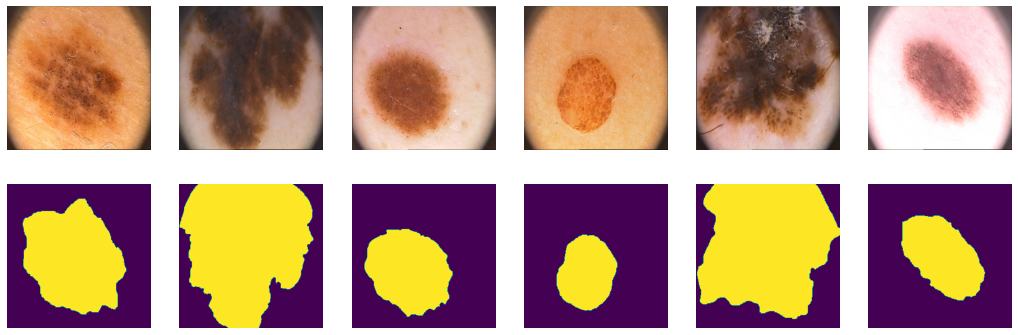

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Делю данные на 100/50/50 для обучения, теста и валидации

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
dataloaders = {}
dataloaders['train'], dataloaders['val'], dataloaders['test'] = data_tr, data_val, data_ts

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

## SegNet

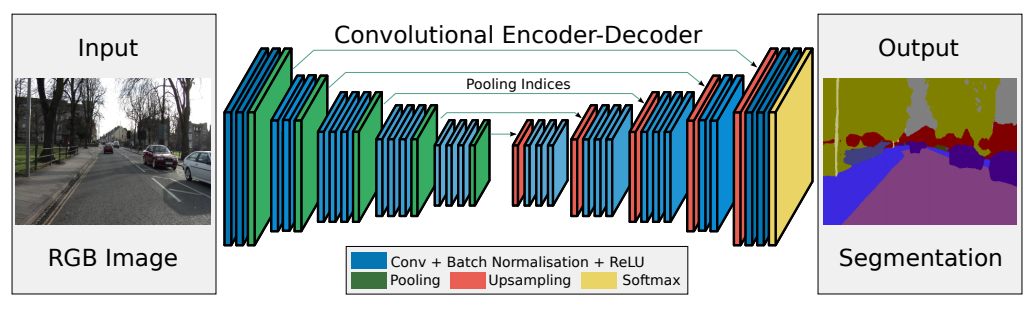

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv_enc = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=(2,2), stride=2, return_indices=True)

        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.bottleneck_conv_dec = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),     
                                         nn.ReLU()
                                         ])

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        size_0 = x.size()
        e0, ind0 = self.pool0(self.enc_conv0(x))

        size_1 = e0.size()
        e1, ind1 = self.pool1(self.enc_conv1(e0))

        size_2 = e1.size()
        e2, ind2 = self.pool2(self.enc_conv2(e1))

        size_3 = e2.size()
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        #bottleneck encoder part
        size_4 = e3.size()
        bottle_enc, bottle_id = self.bottleneck_pool(self.bottleneck_conv_enc(e3))

        #bottleneck decoder part
        size_d = bottle_enc.size()
        bottle_dec = self.bottleneck_conv_dec(self.bottleneck_upsample(bottle_enc, bottle_id, output_size=size_4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(bottle_dec, ind3, output_size=size_3))
    
        d1 = self.dec_conv1(self.upsample1(d0, ind2, output_size=size_2))

        d2 = self.dec_conv2(self.upsample2(d1, ind1, output_size=size_1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0, output_size=size_0)) 
        return d3

In [ ]:
torch.cuda.empty_cache()

#### Метрика

Здесь я использовала следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    
    outputs = outputs.squeeze(1).byte()  
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  
    union = (outputs | labels).float().sum((1, 2))         
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    return iou  # 

#### Функция потерь

Популярным методом для бинарной сегментации является упрощение *бинарной кросс-энтропии*, которая задается следующим образом:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. 

Эта функция эквивалентна *бинарной кросс-энтропии* и не так подвержена численной неустойчивости.



In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1)
    
    epsilon = 10 ** -44
    result = - torch.mean(
        y_real * torch.log(torch.sigmoid(y_pred) + epsilon) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred) + epsilon)
    )

    return result

##### Тренировка

Определяю цикл обучения в функции

In [ ]:
from IPython.display import clear_output
import time
import copy
import seaborn as sns
import gc

In [ ]:
def train(model, optimizer, loss_fn, epochs, data):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_iou = 0.0
    
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_iou = []
    epoch_val_iou = []
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_iou = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    Y_pred = model(inputs)
                    loss = loss_fn(labels, Y_pred)
                    
                    # forward-pass
                    if phase == 'train':
                        loss.backward()  # backward-pass
                        optimizer.step()

                running_loss += loss.detach().item() * inputs.size(0)
                Y_pred = torch.sigmoid(Y_pred)
                Y_pred = torch.where(Y_pred > 0.5, 1, 0)
                running_iou += iou_pytorch(Y_pred, labels).mean().item()
                
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_iou = running_iou / len(dataloaders[phase])
            
            if phase == 'train':
                epoch_train_loss.append(epoch_loss)
                epoch_train_iou.append(epoch_iou)
            else:
                epoch_val_loss.append(epoch_loss)
                epoch_val_iou.append(epoch_iou)
                

            
            if phase == 'val':
                Y_pred = Y_pred.detach().cpu()
                clear_output(wait=True)
                for k in range(5):
                    plt.subplot(2, 5, k+1)
                    plt.imshow(np.rollaxis(inputs[k].cpu().numpy(), 0, 3), cmap='gray')
                    plt.title('Real', fontsize=12)
                    
                    plt.axis('off')

                    plt.subplot(2, 5, k+6)
                    plt.imshow(Y_pred[k, 0], cmap='gray')
                    plt.title('Output', fontsize=12)
                    plt.axis('off')
                plt.suptitle('val Loss: {:.4f} val IOU: {:.4f}'.format(epoch_loss, epoch_iou), fontsize=15)
                plt.show()
                
            inputs, labels = inputs.cpu(), labels.cpu()
            Y_pred, loss = Y_pred.cpu(), loss.cpu()
            #running_loss, running_iou = running_loss.cpu(), running_iou.cpu()
            #epoch_loss, epoch_iou = epoch_loss.cpu(), epoch_iou.cpu()
            del inputs, labels, Y_pred, loss, #running_loss, running_iou, epoch_loss, epoch_iou
            torch.cuda.empty_cache()
            gc.collect()
            
            
            if phase == 'val' and epoch_iou > best_iou:
                best_iou = epoch_iou
                best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val IOU: {:4f}'.format(best_iou))
    
    
    model.load_state_dict(best_model_wts)
    statistics = epoch_train_loss, epoch_train_iou, epoch_val_loss, epoch_val_iou
    #torch.save(model.state_dict(), '/')
    return model, statistics

#### Прогнозирование

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = torch.where(Y_pred > 0.5, 1, 0)

            scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/ len(data)

#### Обучение


In [ ]:
model = SegNet().to(device)

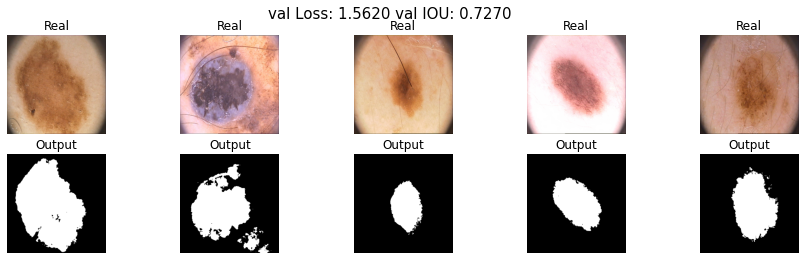


Training complete in 5m 32s
Best val IOU: 0.767472


In [ ]:
max_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.00100)
segnet_best_model_bce, segnet_statistics_with_bce_loss = train(model, optimizer, bce_loss, max_epochs, dataloaders)

In [ ]:
print(score_model(model, iou_pytorch, data_val))
print(score_model(model, iou_pytorch, data_ts))

0.7674722075462341
0.7914747536182404


In [ ]:
import seaborn as sns

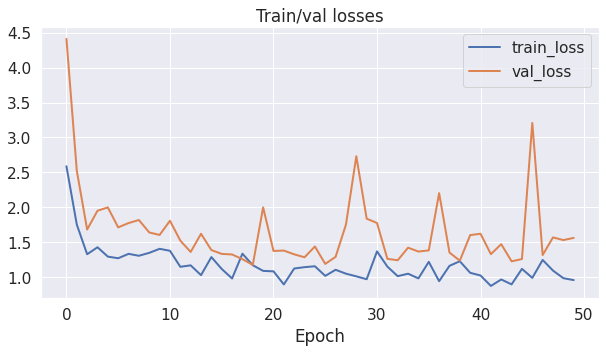

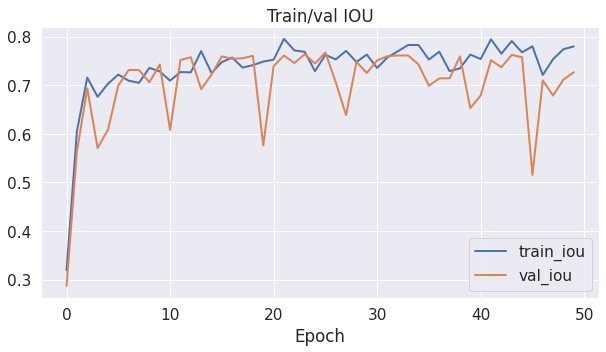

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)


plt.figure(figsize=(10, 5))
plt.title("Train/val losses")
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[0], label="train_loss", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[2], label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()


plt.figure(figsize=(10, 5))
plt.title("Train/val IOU")
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[1], label="train_iou", linewidth=2)
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[3], label="val_iou", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

#### Dice coefficient

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$


In [ ]:
def dice_loss(y_real, y_pred):
    y_pred, y_real = torch.flatten(torch.sigmoid(y_pred)), torch.flatten(y_real)
    epsilon = 10 ** -44
    num = torch.sum(y_pred * y_real)
    den = torch.sum(y_pred + y_real + epsilon)
    res = 1 - 2.*num / den
    return torch.mean(res) 

Провожу тестирование:

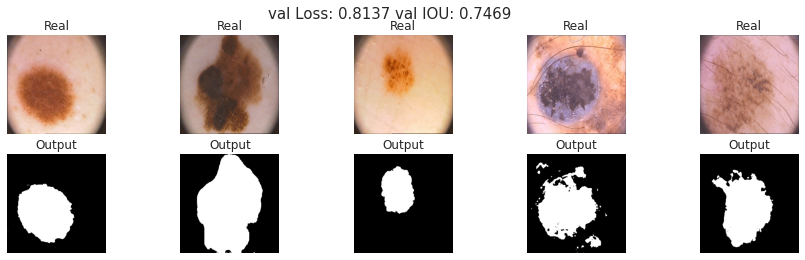


Training complete in 5m 46s
Best val IOU: 0.795991


In [ ]:
model_dice = SegNet().to(device)
optimizer = torch.optim.Adam(model_dice.parameters(), lr=0.00100)
segnet_best_model_dice, segnet_statistics_with_dice_loss = train(model_dice, optimizer, dice_loss, max_epochs, dataloaders)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7959906220436096

#### Focal loss

Взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксирую значение $\gamma=2$.


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred, y_real = torch.unsqueeze(y_pred, 1), torch.unsqueeze(y_real, 1) 
    
    result = -torch.mean(
        ((1 - torch.sigmoid(y_pred)) ** gamma) * y_real * torch.log(torch.sigmoid(y_pred) + eps) + (1 - y_real) * torch.log(
        1 - torch.sigmoid(y_pred) + eps))
    return result

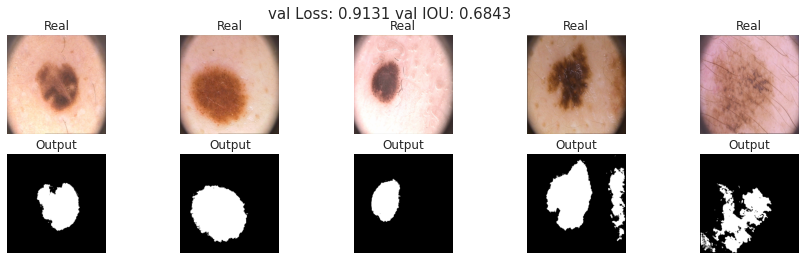


Training complete in 5m 47s
Best val IOU: 0.754709


In [ ]:
model_focal = SegNet().to(device)
max_epochs = 50
optimizer = torch.optim.Adam(model_focal.parameters(), lr=0.00100)
segnet_best_model_focal, segnet_statistics_with_focal_loss = train(model_focal, optimizer, focal_loss, max_epochs, dataloaders)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.7547092139720917

----------------------------------------------------------------------------------------------

#### Tversky loss

In [ ]:
class BinaryTverskyLossV2(nn.Module):

    def __init__(self, alpha=0.3, beta=0.7, ignore_index=None, reduction='mean'):
        super(BinaryTverskyLossV2, self).__init__()
        
        self.alpha = alpha
        self.beta = beta
        self.ignore_index = ignore_index
        self.smooth = 10
        self.reduction = reduction
        s = self.beta + self.alpha
        if s != 1:
            self.beta = self.beta / s
            self.alpha = self.alpha / s

    def forward(self, target, output, mask=None):
        batch_size = output.size(0)
        bg_target = 1 - target
        if self.ignore_index is not None:
            valid_mask = (target != self.ignore_index).float()
            output = output.float().mul(valid_mask)  # can not use inplace for bp
            target = target.float().mul(valid_mask)
            bg_target = bg_target.float().mul(valid_mask)

        output = torch.sigmoid(output).view(batch_size, -1)
        target = target.view(batch_size, -1)
        bg_target = bg_target.view(batch_size, -1)

        P_G = torch.sum(output * target, 1)  # TP
        P_NG = torch.sum(output * bg_target, 1)  # FP
        NP_G = torch.sum((1 - output) * target, 1)  # FN

        tversky_index = P_G / (P_G + self.alpha * P_NG + self.beta * NP_G + self.smooth)

        loss = 1. - tversky_index
        # target_area = torch.sum(target_label, 1)
        # loss[target_area == 0] = 0
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        else:
            loss = torch.mean(loss)
        return loss

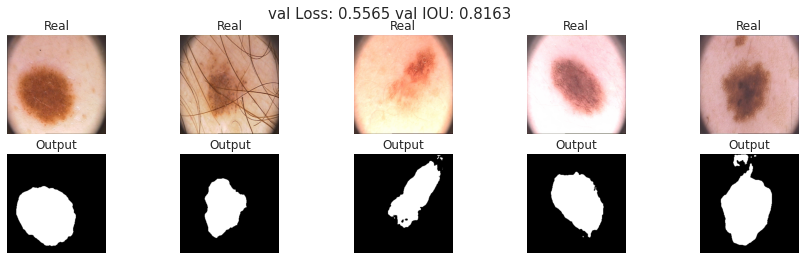


Training complete in 5m 55s
Best val IOU: 0.825420


In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 50
optimizer = torch.optim.Adam(model_tversky.parameters(), lr=1e-4)
tversky_loss = BinaryTverskyLossV2()
segnet_best_model_tversky, segnet_statistics_with_tversky_loss = train(model_tversky, optimizer, tversky_loss, max_epochs, dataloaders)

In [ ]:
score_model(model_tversky, iou_pytorch, data_val)

0.8254203498363495

-----------------------------------------------------------------------------------------

## U-Net

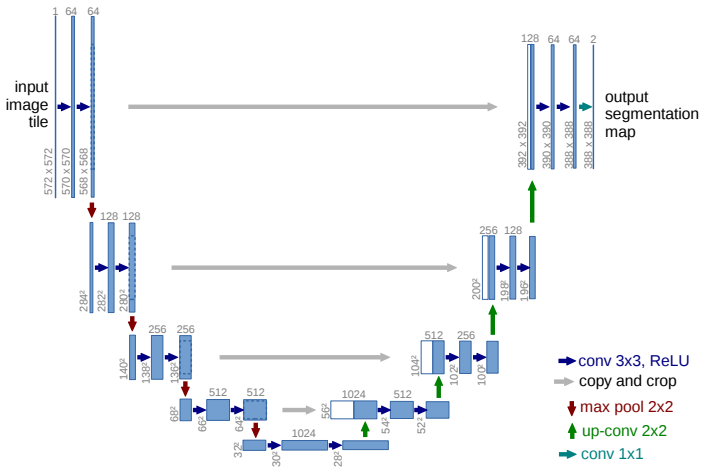

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.pool0 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.pool1 =  nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                        ])
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                        ])

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                        ])

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b, ind3), pre_e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0, ind2), pre_e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1, ind1), pre_e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2, ind0), pre_e0], 1))  # no activation
        return d3

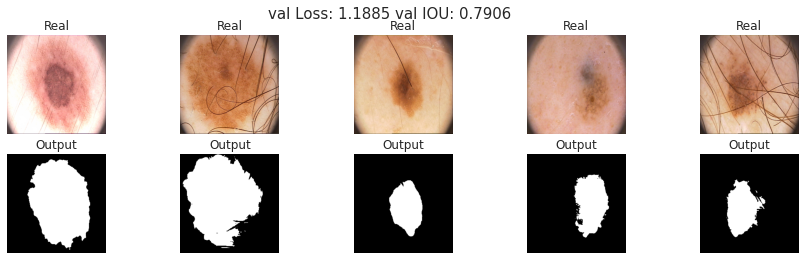


Training complete in 5m 39s
Best val IOU: 0.801282


In [ ]:
unet_model = UNet().to(device)
unet_best_model_bce, unet_statistics_with_bce_loss = train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 50, dataloaders)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.8012817025184631

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)



In [ ]:
class UNet_2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.pool0 =  nn.MaxPool2d(3, 2, padding=1, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.pool1 =  nn.MaxPool2d(3, 2, padding=1, return_indices=True)# 128 -> 64
        self.enc_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.pool2 = nn.MaxPool2d(3, 2, padding=1, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                        ])
        self.pool3 = nn.MaxPool2d(3, 2, padding=1, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(1024),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU()
                                        ])

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32, mode ='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU()
                                        ])
        self.upsample1 = nn.Upsample(64, mode ='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU()
                                        ])
        self.upsample2 = nn.Upsample(128, mode ='nearest')  # 64 -> 128
        self.dec_conv2 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=256, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU()
                                        ])
        self.upsample3 = nn.Upsample(256, mode ='nearest')  # 128 -> 256
        self.dec_conv3 = nn.Sequential(*[
                                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                        ])

    def forward(self, x):
        # encoder
        pre_e0 = self.enc_conv0(x)
        e0, ind0 = self.pool0(pre_e0)
        pre_e1 = self.enc_conv1(e0)
        e1, ind1 = self.pool1(pre_e1)
        pre_e2 = self.enc_conv2(e1)
        e2, ind2 = self.pool2(pre_e2)
        pre_e3 = self.enc_conv3(e2)
        e3, ind3 = self.pool3(pre_e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.cat([self.upsample0(b), pre_e3], 1))
        d1 = self.dec_conv1(torch.cat([self.upsample1(d0), pre_e2], 1))
        d2 = self.dec_conv2(torch.cat([self.upsample2(d1), pre_e1], 1))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), pre_e0], 1))  # no activation
        return d3

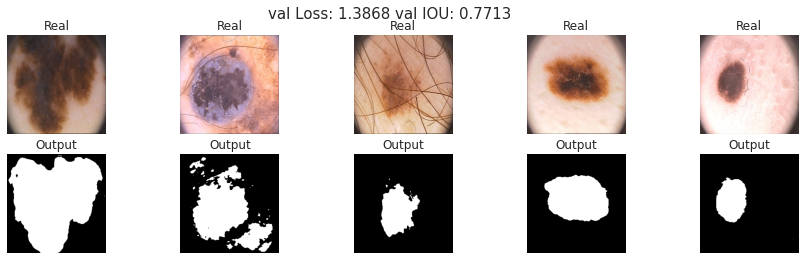


Training complete in 5m 38s
Best val IOU: 0.798505


In [ ]:
unet_model_2 = UNet_2().to(device)
unet_best_model_bce_2, unet_statistics_with_bce_loss_2 = train(unet_model_2, optim.Adam(unet_model_2.parameters()), bce_loss, 50, dataloaders)

In [ ]:
score_model(unet_model_2, iou_pytorch, data_val)

0.7985049903392791

### Статистика для Segnet

In [ ]:
train_stat_loss_segnet = [segnet_statistics_with_bce_loss[0], segnet_statistics_with_dice_loss[0], 
                          segnet_statistics_with_focal_loss[0], segnet_statistics_with_tversky_loss[0]]
train_stat_iou_segnet = [segnet_statistics_with_bce_loss[1], segnet_statistics_with_dice_loss[1], 
                          segnet_statistics_with_focal_loss[1], segnet_statistics_with_tversky_loss[1]]
val_stat_loss_segnet = [segnet_statistics_with_bce_loss[2], segnet_statistics_with_dice_loss[2], 
                          segnet_statistics_with_focal_loss[2], segnet_statistics_with_tversky_loss[2]]
val_stat_iou_segnet = [segnet_statistics_with_bce_loss[3], segnet_statistics_with_dice_loss[3], 
                          segnet_statistics_with_focal_loss[3], segnet_statistics_with_tversky_loss[3]]

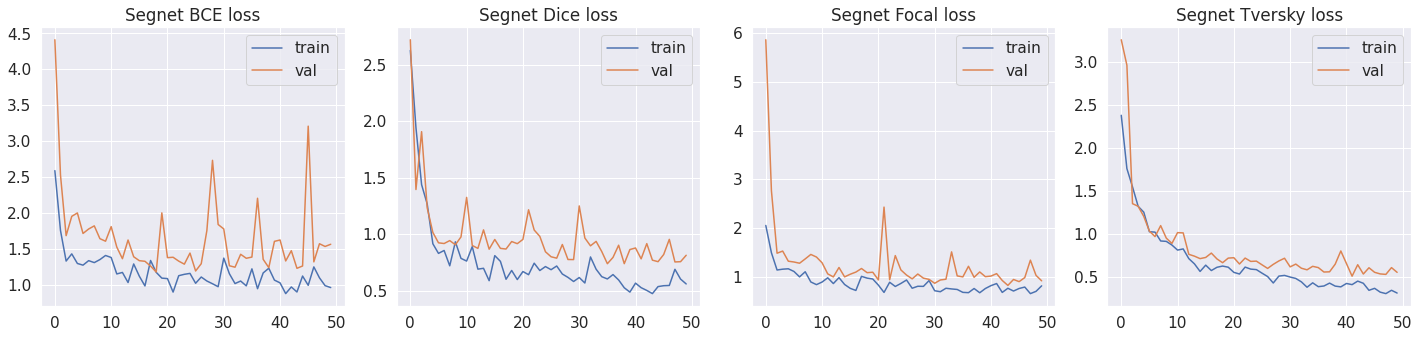

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
axe = ax.ravel()
losses = ['BCE', 'Dice', 'Focal', 'Tversky']
for num, (train, val, loss) in enumerate(zip(train_stat_loss_segnet, val_stat_loss_segnet, losses)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Segnet {loss} loss')
    axe[num].legend()
plt.tight_layout()

Графики лоссов на Segnet показывают, что BCE и Dice лоссы начинают переобучаться с 15-20 эпохи. Tversky и Focal можно продолжать обучать спокойно дальше.

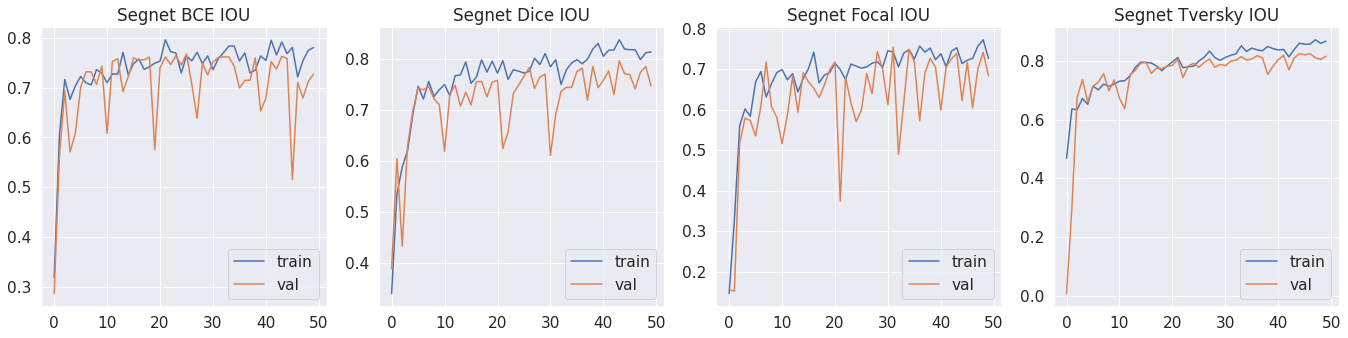

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(19, 5))
axe = ax.ravel()
losses_iou = ['BCE', 'Dice', 'Focal', 'Tversky']
for num, (train, val, loss) in enumerate(zip(train_stat_iou_segnet, val_stat_iou_segnet, losses_iou)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(f'Segnet {loss} IOU')
    axe[num].legend()
plt.tight_layout()

По графикам можно видеть, что лучше всего себя показали модели с лоссом Dice и Tversky. На некоторых эпохах IOU всех моделей, кроме модели с Tversky loss, нестабильны

#### Сравнение IOU для Segnet по всем loss

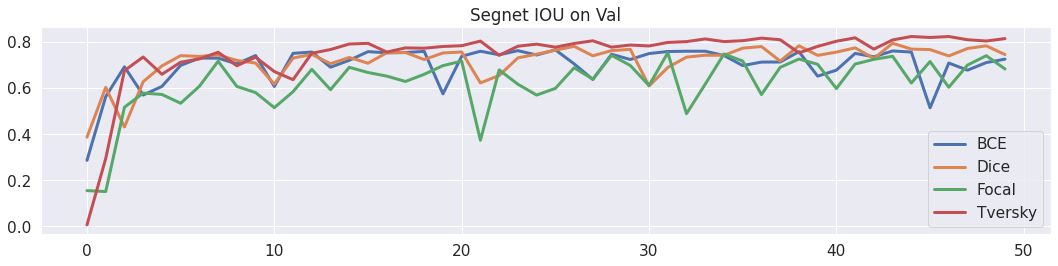

In [ ]:
plt.plot(range(max_epochs), segnet_statistics_with_bce_loss[3], label='BCE', linewidth=3)
plt.plot(range(max_epochs), segnet_statistics_with_dice_loss[3], label='Dice', linewidth=3)
plt.plot(range(max_epochs), segnet_statistics_with_focal_loss[3], label='Focal', linewidth=3)
plt.plot(range(max_epochs), segnet_statistics_with_tversky_loss[3], label='Tversky', linewidth=3)
plt.title('Segnet IOU on Val')
plt.legend()
plt.tight_layout()

Лучшим loss для Segnet оказался Tversky

### Статистика для Unet

In [ ]:
train_stat_loss_unet = [unet_statistics_with_bce_loss[0], unet_statistics_with_bce_loss_2[0]]
train_stat_iou_unet = [unet_statistics_with_bce_loss[1], unet_statistics_with_bce_loss_2[1]]
val_stat_loss_unet = [unet_statistics_with_bce_loss[2], unet_statistics_with_bce_loss_2[2]]
val_stat_iou_unet = [unet_statistics_with_bce_loss[3], unet_statistics_with_bce_loss_2[3]]

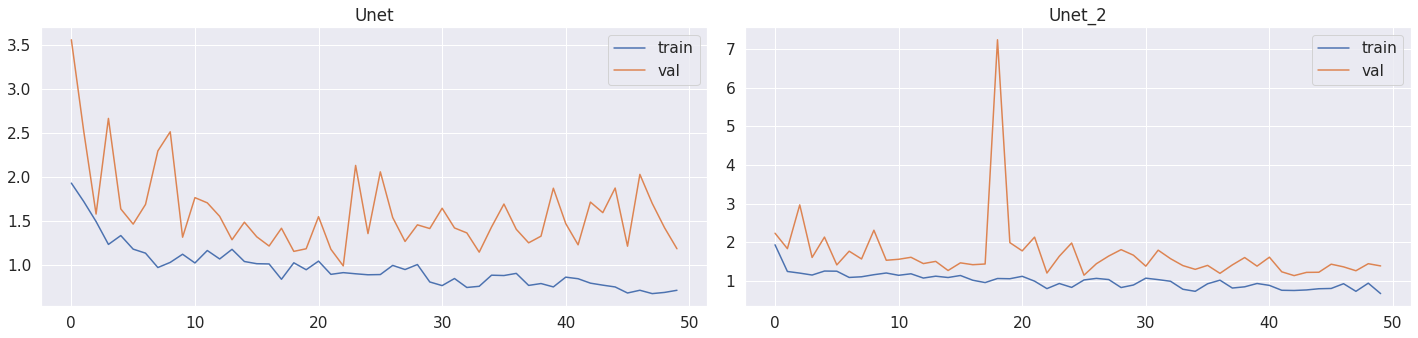

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
axe = ax.ravel()
models = ['Unet', 'Unet_2']
for num, (train, val, mod) in enumerate(zip(train_stat_loss_unet, val_stat_loss_unet, models)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(mod)
    axe[num].legend()
plt.tight_layout()

Видно, что и Unet, и Unet_2 склонны к переобучению после 15-20 эпохи

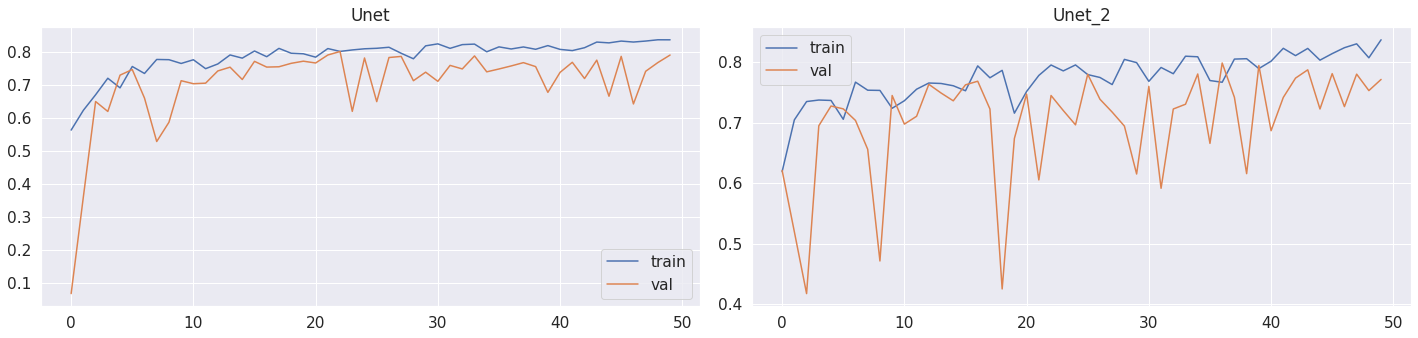

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
axe = ax.ravel()
models = ['Unet', 'Unet_2']
for num, (train, val, mod) in enumerate(zip(train_stat_iou_unet, val_stat_iou_unet, models)):
    axe[num].plot(range(max_epochs), train, label=f'train')
    axe[num].plot(range(max_epochs), val, label=f'val')
    axe[num].set_title(mod)
    axe[num].legend()
plt.tight_layout()

Из графиков видно, что IOU для Unet более стабильна, чем для Unet_2

### Сравнение IOU для Unet и Unet_2 на validation

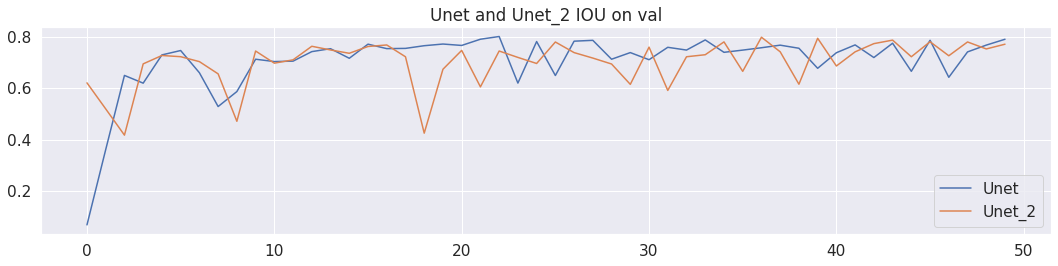

In [ ]:
plt.plot(range(max_epochs), val_stat_iou_unet[0], label='Unet')
plt.plot(range(max_epochs), val_stat_iou_unet[1], label='Unet_2')
plt.title('Unet and Unet_2 IOU on val')
plt.legend()
plt.tight_layout()

Unet и Unet_2 показали себя примерно одинаково, однако IOU Unet более устойчиво